# Bayesian Optimization

scikit-learn "Gaussian Processes"  
https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process

scikit-learnは以下の文献を参考に実装している。  
C. E. Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning, the MIT Press, 2006,

ref)

Instruction of chemoinformatics "Gaussian Process"  
https://funatsu-lab.github.io/open-course-ware/machine-learning/gaussian-process/

ベイズ最適化入門  
https://qiita.com/masasora/items/cc2f10cb79f8c0a6bbaa

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from scipy.linalg import cholesky, cho_solve, solve_triangular
from scipy.spatial.distance import pdist, cdist, squareform

from sklearn.base import BaseEstimator, RegressorMixin

plt.style.use('seaborn')

In [2]:
class MyGaussianProcess(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.X = None
        self.y = None
        self.y_mean = None
        self.scale = None
        
        self.K_n = None
        self.L_ = None
        self.alpha_ = None
    
    def fit(self, X, y):
        # Traing data
        self.x_train = np.atleast_2d(X).reshape(-1, 1)
        self.y_train = np.atleast_2d(y).reshape(-1, 1)
        
        self.y_mean = np.mean(self.y_train)
        y_train_ = self.y_train - self.y_mean
        
        # Kernel
        K_n = self.kernel(self.x_train, self.x_train) + np.eye(X.shape[0]) * 1e-10
        self.L_ = cholesky(K_n, lower=True)  # Line 2
        self.alpha_ = cho_solve((self.L_, True), y_train_)  # Line 3

    def predict(self, X):
        if not hasattr(self, 'x_train'):
            y_pred = np.zeros(X.shape[0])
            y_std = self.kernel(X).diagonal()
            
            return y_pred, y_std
            
        # Kernel
        K_x = self.kernel(X, self.x_train)
        K_xx = self.kernel(X)
        
        # Mean prediction
        y_pred = K_x.dot(self.alpha_)  # Line 4
        
        # Std
        L_inv = solve_triangular(self.L_.T, np.eye(self.L_.shape[0]))
        K_inv = L_inv.dot(L_inv.T)  # Line 5
        
        y_std = K_xx.diagonal()  # Line 6
        y_std = y_std - np.einsum('ij,ij->i', np.dot(K_x, K_inv), K_x)  # Line 6
        
        y_std_negative = y_std < 0
        if np.any(y_std_negative):
            y_std[y_std_negative] = 0.
        
        # Inverse transform
        y_pred = y_pred + self.y_mean
        y_std = y_std.reshape(-1, 1)
        
        return y_pred, y_std

    def kernel(self, X, Y=None, scale=1.0, constant=1.0):
        return self.constant_kernel(X, Y) * self.rbf_kernel(X, Y)
    
    @staticmethod
    def rbf_kernel(X, Y=None, scale=1.0):
        X = np.atleast_2d(X)

        # Computes the Squared Euclidean distance.
        if Y is None:
            dists = pdist(X / scale, metric='sqeuclidean')
            K = np.exp(- .5 * dists)
            # convert from upper-triangular matrix to square matrix
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X / scale, Y / scale, metric='sqeuclidean')
            K = np.exp(- .5 * dists)
        return K
    
    @staticmethod
    def constant_kernel(X, Y=None, constant=1.0):    
        if Y is None:
            return np.full((X.shape[0], X.shape[0]), constant)
        else:
            return np.full((X.shape[0], Y.shape[0]), constant)

# Gaussian Process Regression

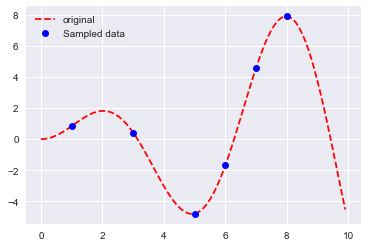

In [3]:
def sample(x):
    return x * np.sin(x)

x = np.atleast_2d(np.arange(0, 10, 0.1)).T

# Generated sample
x_train = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
y_train = sample(x_train)

plt.plot(x, sample(x), 'r--', label='original')
plt.plot(x_train, y_train, 'bo', label='Sampled data')
plt.legend()
plt.show()

In [4]:
gp = MyGaussianProcess()
gp.fit(x_train, y_train)
y_pred, y_std = gp.predict(x)

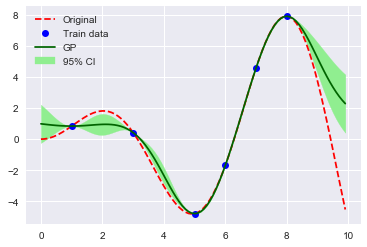

In [5]:
plt.plot(x, sample(x), 'r--', label='Original')
plt.plot(x_train, y_train, 'bo', label='Train data')
plt.plot(x, y_pred, 'darkgreen', label='GP')
plt.fill_between(x.squeeze(), (y_pred - 1.96 * y_std).squeeze(),
                 (y_pred + 1.96 * y_std).squeeze(),
                 color='lightgreen', label='95% CI') 
plt.legend()
plt.show()

# Expected Improvement

In [6]:
def expected_improvement(y_pred, y_std, x_train=None, xi=0.01):
    if x_train is not None:
        fmax = np.max(x_train)
    else:
        fmax = 0
    
    z_tmp = y_pred - fmax - xi
    Z = z_tmp / y_std
    return z_tmp * stats.norm.cdf(Z) + y_std * stats.norm.pdf(Z)

In [7]:
def acquision_max(acq):
    return np.argmax(acq)

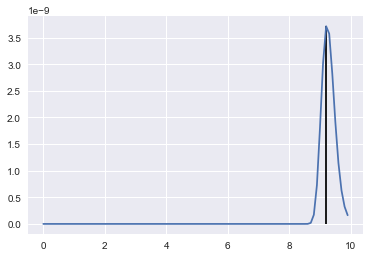

In [8]:
acq = expected_improvement(y_pred, y_std, x_train)
acq_argmax = acquision_max(acq)

plt.plot(x, acq)
plt.vlines(x=x[acq_argmax], ymin=acq.min(), ymax=acq.max())

# Bayesian Optimization

In [19]:
def bo_func(x, y, gp, f_aq, acq, x_train=None, y_train=None, title=''):
    
    # ----------------------------------------
    # Bayesian Optimization
    # ----------------------------------------
    
    # Prediction
    if x_train is not None and y_train is not None:
        gp.fit(x_train, y_train)
    y_pred, y_std = gp.predict(x)
    
    # Acquisition function
    acq = f_aq(y_pred, y_std, x_train)
    acq_argmax = acquision_max(acq)
    
    # ----------------------------------------
    # Plot
    # ----------------------------------------
    
    # Plot 
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    ax1.grid(True)
    ax2.grid(False)
    
    # ----------------------------------------
    # 1st Plot
    # ----------------------------------------

    # True data
    ax1.plot(x, y, 'r--', label='Original')
    
    
    # Train data
    if x_train is not None and y_train is not None:
        ax1.plot(x_train, y_train, 'bo', label='Train data')
    
    # GP
    ax1.plot(x, y_pred, 'darkgreen', label='GP')
    ax1.fill_between(x.squeeze(), (y_pred - 1.96 * y_std).squeeze(),
                         (y_pred + 1.96 * y_std).squeeze(),
                         color='lightgreen', label='95% CI')
    ax1.set_ylabel('Data')
    
    # ----------------------------------------
    # 2nd Plot
    # ----------------------------------------

    ax2.plot(x, acq, 'b', label='Acq func')
    ax2.vlines(x[acq_argmax], 0, 5 * np.max(acq),
               colors='blue', linestyles='--', label='Acq max')
    ax2.set_ylim([0, 5 * np.max(acq)])
    ax2.set_ylabel('Acquisition Function')
    
    # ----------------------------------------
    # Layout
    # ----------------------------------------

    # Legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='upper left')
    
    plt.suptitle(title)
    fig.tight_layout()
    plt.show()

    return acq_argmax

In [20]:
def bo_process(x, func, gp, expected_improvement, acquision_max, n_steps=10):
    x_train = np.array([])
    y_train = np.array([])
    
    # Plot prior
    acq_argmax = bo_func(x, func(x), gp, expected_improvement, acquision_max)
    
    # Bayesian optimization
    for i in range(n_steps):
        x_train = np.append(x_train, x[acq_argmax])
        y_train = np.append(y_train, sample(x[acq_argmax]))

        # Optimize & plot
        acq_argmax = bo_func(x, sample(x), gp, expected_improvement, acquision_max,
                             x_train, y_train, title='Step {}'.format(i))

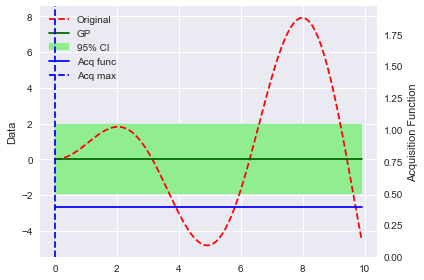

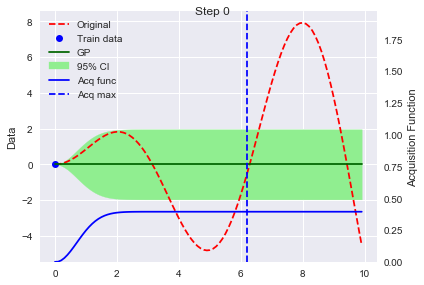

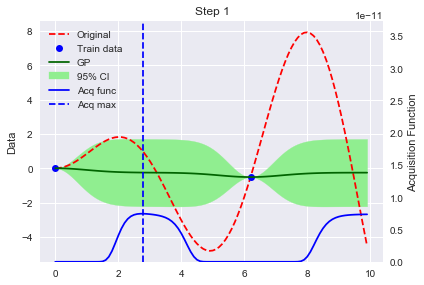

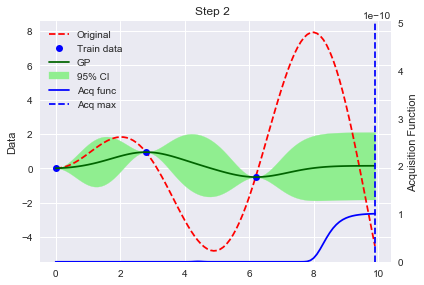

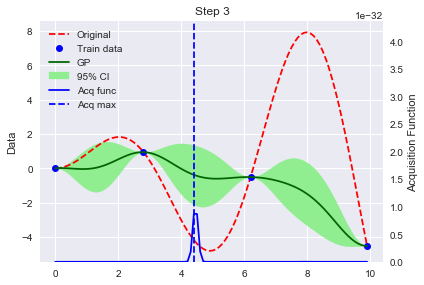

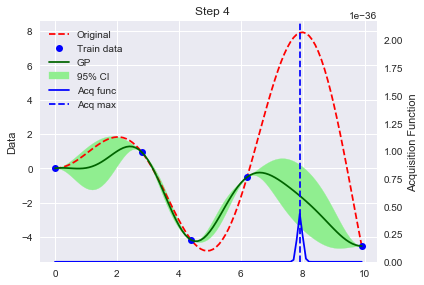

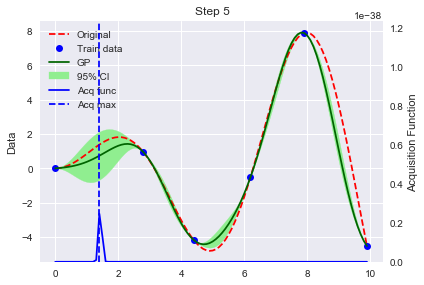

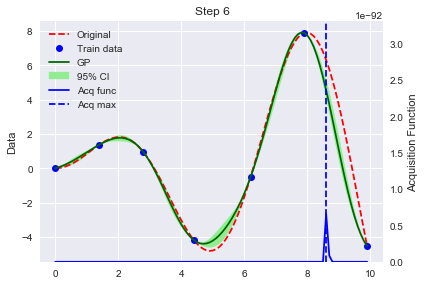

C:\Users\4046291\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


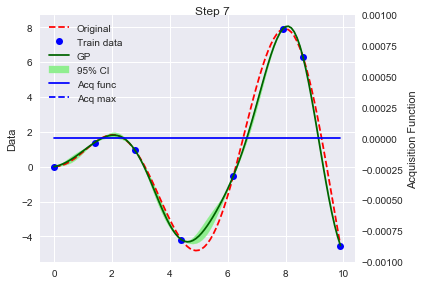

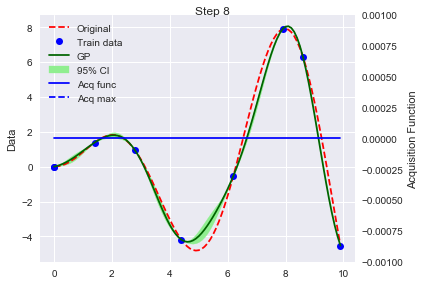

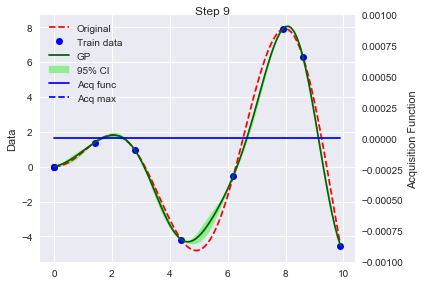

In [21]:
def sample(x):
    return x * np.sin(x)

# Domain
x = np.atleast_2d(np.arange(0, 10, 0.1)).T

# Gaussian Process
gp = MyGaussianProcess()

# Start BO
bo_process(x, sample, gp, expected_improvement, acquision_max)